In [1]:
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics import mape
from darts.models import TransformerModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
from pathlib import Path
import os
from tqdm import tqdm
# from src_transformers.preprocessing.multi_symbol_dataset import MultiSymbolDataset

c:\Users\lucan\.conda\envs\dl2\Lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [9]:
file_path = Path(os.getcwd()).parents[0]
file_path = Path(file_path, "data", "input", "us3000_tickers_A-B_1min_iqksn", "AAPL_1min.txt")
print(file_path.absolute())

dataset = pd.read_csv(file_path, names=["Date", "Open", "High", "Low", "Close", "Volume"])
print(dataset.info())

dataset = dataset[["Date","Close"]]
dataset["Timestamp"] = pd.to_datetime(dataset["Date"], format="%Y-%m-%d %H:%M:%S")
dataset["Date"] = pd.DatetimeIndex(dataset["Timestamp"]).date
print(dataset.info())

c:\Users\lucan\Documents\Git Projects\Deep_Learning\data\input\us3000_tickers_A-B_1min_iqksn\AAPL_1min.txt
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655629 entries, 0 to 2655628
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 121.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655629 entries, 0 to 2655628
Data columns (total 3 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Date       object        
 1   Close      float64       
 2   Timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 60.8+ MB
None


In [10]:
print(dataset["Date"].values)
print()
print(dataset["Timestamp"].values)

[datetime.date(2004, 1, 2) datetime.date(2004, 1, 2)
 datetime.date(2004, 1, 2) ... datetime.date(2021, 3, 19)
 datetime.date(2021, 3, 19) datetime.date(2021, 3, 19)]

['2004-01-02T08:06:00.000000000' '2004-01-02T09:10:00.000000000'
 '2004-01-02T09:20:00.000000000' ... '2021-03-19T19:57:00.000000000'
 '2021-03-19T19:58:00.000000000' '2021-03-19T19:59:00.000000000']


In [11]:
print(dataset.shape)
dataset = dataset.tail(300000)
print(dataset.shape)

(2655629, 3)
(300000, 3)


In [12]:
datasets = []

print(len(np.unique(dataset["Date"])))

for unique_date in tqdm(np.unique(dataset["Date"])):
    df = dataset[dataset["Date"] == unique_date].copy()
    df.drop("Date", inplace=True, axis=1)
    datasets.append(df)

print(len(datasets))

384


100%|██████████| 384/384 [00:05<00:00, 73.79it/s]

384


In [17]:
timeseries = []

for dataset in datasets:
    ts = TimeSeries.from_dataframe(dataset, time_col="Timestamp", value_cols=["Close"], fill_missing_dates=True, freq="T")
    df = ts.pd_dataframe().ffill().bfill()
    ts = TimeSeries.from_dataframe(df, value_cols=["Close"])
    timeseries.append(ts)

print(len(timeseries))

384


In [23]:
scaler = MinMaxScaler(feature_range=(-1, 1))
transformer = Scaler(scaler)

train_series, val_series = [], []

for ts in timeseries:
    train, val = ts.split_after(0.8)
    
    transformer.fit(ts)

train_series, val_series = timeseries[:300], timeseries[300:]
train_scaled, val_scaled = [], []

scaler = Scaler()

# for ts in train_series:
#     scaler.fit(ts)
    
for ts in train_series:
    train_scaled.append(scaler.fit_transform(ts))
    
for vs in val_series:
    val_scaled.append(scaler.transform(vs))

<Axes: xlabel='Timestamp'>

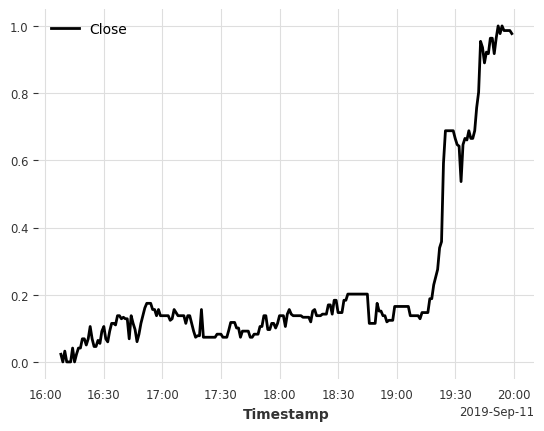

In [25]:
train_scaled[0].plot()

<Axes: xlabel='Timestamp'>

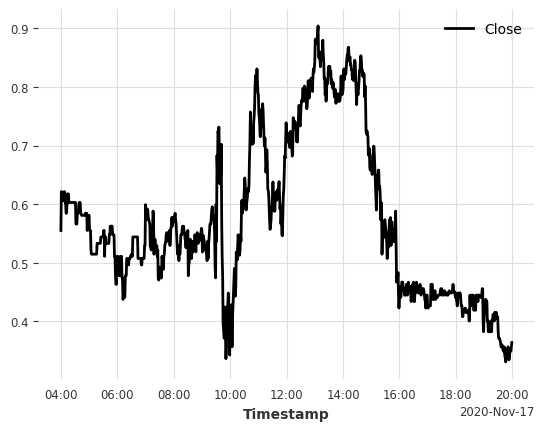

In [26]:
val_scaled[0].plot()

In [28]:
my_model = TransformerModel(
    input_chunk_length=20,
    output_chunk_length=1,
    batch_size=1024,
    n_epochs=20,
    model_name="single_aktie4",
    d_model=16,
    nhead=8,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    log_tensorboard=True,
    work_dir="../runs"
)

In [29]:
my_model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

c:\Users\lucan\.conda\envs\dl2\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 32    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer    

Epoch 19: 100%|██████████| 276/276 [01:58<00:00,  2.33it/s, v_num=logs, train_loss=0.00119, val_loss=12.30] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 276/276 [01:58<00:00,  2.33it/s, v_num=logs, train_loss=0.00119, val_loss=12.30]


TransformerModel(d_model=16, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=128, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=20, output_chunk_length=1, batch_size=1024, n_epochs=20, model_name=single_aktie4, random_state=42, save_checkpoints=True, log_tensorboard=True, work_dir=../runs)

In [30]:
def eval_model(model, actual, series, val_series):
    pred_series = model.predict(series=series, n=len(val_series))
    plt.figure(figsize=(8, 5))

    actual.plot(label="actual")
    pred_series.plot(label="forecast")
    
    print(pred_series)

    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))

    plt.legend()
    plt.show()

In [31]:
len(val_scaled)

84

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.70it/s]
<TimeSeries (DataArray) (Timestamp: 192, component: 1, sample: 1)>
array([[[0.43475146]],

       [[0.42230321]],

       [[0.40998935]],

       [[0.39820514]],

       [[0.38671059]],

       [[0.37565794]],

       [[0.36486864]],

       [[0.35452571]],

       [[0.34464313]],

       [[0.33496961]],

...

       [[0.02936631]],

       [[0.02936626]],

       [[0.02936621]],

       [[0.02936617]],

       [[0.02936613]],

       [[0.0293661 ]],

       [[0.02936607]],

       [[0.02936604]],

       [[0.02936602]],

       [[0.029366  ]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2020-11-17T16:48:00 ... 2020-11-17T...
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


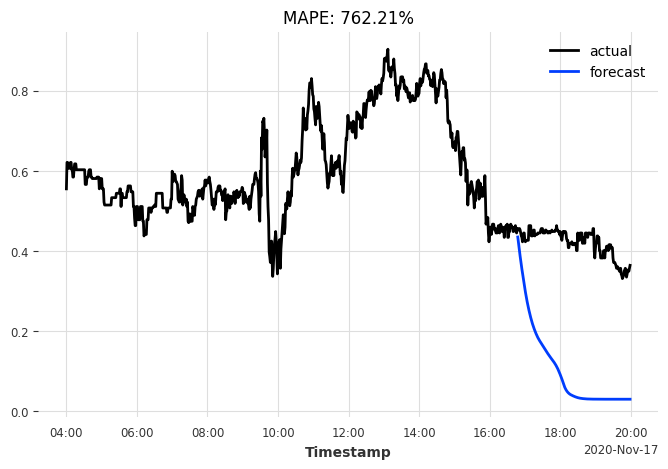

In [32]:
actual = val_scaled[0]
act, val = actual.split_after(0.8)
eval_model(my_model, actual, act, val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.73it/s]
<TimeSeries (DataArray) (Timestamp: 192, component: 1, sample: 1)>
array([[[ 0.0104299 ]],

       [[-0.00165921]],

       [[ 0.00378987]],

       [[ 0.0067417 ]],

       [[ 0.0081277 ]],

       [[ 0.00876424]],

       [[ 0.00985377]],

       [[ 0.01135766]],

       [[ 0.01224631]],

       [[ 0.01276278]],

...

       [[ 0.02936582]],

       [[ 0.02936582]],

       [[ 0.02936582]],

       [[ 0.02936582]],

       [[ 0.02936582]],

       [[ 0.02936582]],

       [[ 0.02936582]],

       [[ 0.02936582]],

       [[ 0.02936582]],

       [[ 0.02936582]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2020-11-18T16:48:00 ... 2020-11-18T...
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


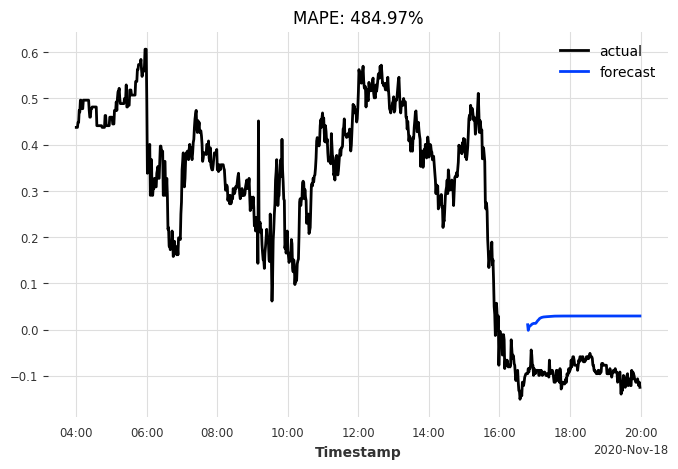

In [33]:
actual = val_scaled[1]
act, val = actual.split_after(0.8)
eval_model(my_model, actual, act, val)